---
title: "Nested cross validation is an Important Thing"
author: Marshall Krassenstein
date: '2022-07-07'
slug: nested-cross validation
categories: []
tags: [python, partitioning, machine-learning]
subtitle: ''
summary: 'A tutorial on what nested cross validation is, why it is important and how to implement it in Python'
authors: [Marshall Krassenstein]
featured: yes
image:
  caption: ''
  focal_point: ''
  preview_only: no
projects: []
---

 Nested cross validation is cross validation methodlogy that can provide better estimates of model performance on held out data. In this tutorial I will provide an explanation of what nested cross validation is, why you should use it, and how to implement in scikit-learn. 

### Prerequisites

You should read on in this tutorial if:
- Explanation: You have a basic understanding of what cross validation is
- Implementation: You have at least passing familiarity with the `scikit-learn` package

## What we already know about partitioning

If your job title has the phrase 'Data Science' or 'Machine Learning' in it, you're probably familiar with the idea of partitioning your data before you fit a model. Whether you are fitting just one model with a predefined set of hyperparameters or many models as well, you need some way to evaluate how well they will perform in 'in the wild'. Any attempt to assess the performance of a model on the same data you trained on will produce overfit results where the most wiggly models appear to perform amazingly well. Once the model is deployed and making predictions on data that the model has never seen before, you discover that they're hot pieces of trash. If you don't believe me on this point, well, this article probably isn't for you. So, normally we split our data into a **training set** to build the model and a test or **holdout set** to evaluate the model. Ideally, this holdout set tells us how good our model is at predicting on unseen data. So, we might split our data like this:

![train and holdout set](images/train_holdout.png)

Now if this article is for you, then you probably also realize that you need more than just a training and a holdout set if you want to evaluate multiple models or if you want to tune hyperparameters. Ideally, we need one more dataset that will help us choose the best tool for the problem, which we can then pass to the holdout set to evaluate that best model. We call this 'choose your model and hyperparameter space' set the **validation set**. And that might look like this:

![train validate and holout set](images/train_validate_holout.png)

Now before we go on, please do pay attention to the above claim and make sure you understand why you can't use your holdout set both for choosing between hyperparameter options **and** for evaluating the chosen model. I will return to this idea, because it is the most important piece to understanding why nested cross validation is so important. 

But first I want to talk through one more point. Now, continuing the hypothesis that you are the intended audience of this article, I will further surmise that you are also familiar with cross validation, the magical and commonly used data slicing strategy that lets you turn your training data into a debiased validation set. Effectively, you take your training dataset cut it into *n* equally sized pieces, fit a model using all of the data in *n-1* pieces, then evalute on the remaining piece. You repeat this process until each piece has been used as the single evaluating dataset. cross validation looks like this:

![cross validation](images/cross_validation.jpeg)


Using cross validation gives you two big advantages compared to using a train/validation split: 
1. All of the data that is not in your holdout set is used for model training. 
2. All of the data that is not in your holdout set is used for model validation.

So, cross validation is great. It gives you more training data and more data to determine the best model among a set of models. The only real downside to cross validation is that doing it requires you to fit a model once for every **fold**, or the number of times you want to split your data. So, if you use five fold cross validations, you could expect about 5x more time needed to fit your model.


### So what's the Problem?

Up to this point, we've defined our train, validation, and holdout sets. We even talked about a nifty algorithm for merging the training and validation sets so that we can both fit our model and select its hyperparameters using the same set of data. You might wonder, "Maybe there's some secret mathematical issue with cross validation?" But the issue is not with cross validation at all. In fact, if you truly do just use cross validation to train and select your model, leaving evaluation to your holdout set, then there actually isn't anything wrong with the above process. 

The problem is that most of the time we do not actually follow this process. To explain why most people don't do this and why that presents us with a problem, I will leave off cross validation for now and return to using a regular train, validate, holdout partitioning scheme for training, tuning and evaluating model performance.

### Introducing Leakage

Let's say I want to train a random forest classifier on a dataset. I'm not sure how deep the trees should be, and I'm not sure how many trees to use. Being the classy practitioner I am, I decide to define a grid of hyperparameters, maybe with tree depths of 3, 5 and 10 and a number of trees of 30, 100, and 200. That grid would build nine different random forest models and might look like this:
![trees](images/grid_search.jpg)

Since I have my validation set, I can train a model on each of these trees, and then find the best hyperparameter space by choosing the best performing model on the validation set. Maybe a tree depth and number of trees combination of 5 and 200 is the best performer. If I want to know how well it performed, I can assess my (5,200) random forest on whatever metrics interest me using the holdout dataset.  So far, so good. Except, wait, my performance on the holdout set really is not *that* much better than some of the other models. In fact, it seems like if I only trained a model with 100 trees, I could cut the time it takes to train in half with a minimal loss in performance. Maybe evaluating that model on the holdout set will even perform *better* when I look at some other metrics of evaluation than what I had originally considered. And actually, I did not test some other hyperparameters. A model using 70 trees could perform just as well as one with 100 trees. Oh, modeling is such an *iterative process*.

So, I could restart the modeling process with a new hyperparameter space. And then I can keep following this process until I have a model with satisfactory performance on the holdout set. But there's a problem here. If I keep redoing my models until my holdout score is adequate, I'm essentially just gaming the model fitting process because some configuration of the model is destined to perform better than others on *this sample of data*. Another way for me to say this is that I am indirectly introducing **leakage** to my training data by incorporating my knowledge of performance on the holdout set to the modeling process. 

Incorporating any knowledge about the holdout set into the modeling process is bad because when I build my holdout set I make the assumption that it is representative of unseen, real world data. Encoding any knowledge of that data into the model violates this assumption and creates overfit models. At the end of the day, I should not use the holdout set iteratively. It is meant to be evaluated at the latest stage of the modeling process and **only** the latest stage of the modeling process.

### Validating on the validation set

Alright, so we know I should only use the holdout set to evaluate the final model, not to choose between models. What can I do instead? My next instinct might be to use the validation set as a preliminary performance evaluation for my model. After all, the model I choose to evaluate on the holdout set is the result of comparing a performance metric for each model trained using the validation set.  The problem with doing this is that one model is destined to perform better than every other model we fit even if it is not necessarily a better model. A thought experiment might illustrate this idea. 

Let's say I have 3 friends named Jonathan, Joseph, and Jolyne. I'm trying to decide who I should bring to a casino with me but I think they have different levels of luck. I hypothesize that when one of them flips a coin and the coin is supposed to be heads, it will be more likely to be heads and vice versa. I make a table of 10 coin flips I want and have each of them flip a coin ten times. The results might look like this:

![Coin Flips](images/coin_flips.jpg)

Amazing! Joseph flipped all but two of the coins exactly how he was supposed to. Good thing I'm not bringing Jonathan who must be very unlucky.

Obviously, this was a bit of a silly hypothesis. But what I hope it illustrates is that someone is destined to win even here even when there isn't a difference between three candidates. In the same vein, when you draw conclusions about how good your model is based on the exact dataset you used to select the model in the first place you are likely to get an overly optimistic evaluation of performance. 

### Enter Nested CV

Cross validation suffers from exactly the same problem as making a validation split. If it is used to decide between model hyperparameters, it shouldn't also be used to evaluate the winning model. This is exactly what you can read in the [scikit-learn documentaiton](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html), which also explains what Nested Cross validation is for:

*"..Choosing the parameters that maximize non-nested CV biases the model to the dataset, yielding an overly-optimistic score... Nested cross validation (CV) is often used to train a model in which hyperparameters also need to be optimized. Nested CV estimates the generalization error of the underlying model and its (hyper)parameter search."*


#### How Nested Cross Validation Works

The scikit-learn docs can also give us insight into how nested cross validation works: 

*"Nested CV effectively uses a series of train/validation/test set splits. In the inner loop, the score is approximately maximized by fitting a model to each training set, and then directly maximized in selecting (hyper)parameters over the validation set. In the outer loop, generalization error is estimated by averaging test set scores over several dataset splits."*

Bsically, what's happening is a process like this:
- Separate out your holdout set. This will not be involved in the model fitting process. Let's call that 20% of the data, leaving 80% of the data to be used in the next steps.
- Use cross validation on your remaining dataset. Let's say we're using 5-fold cross validation. This will split the remaining 80% of the data into 5 equal parts (16% each).
- For each iteration:
    - Consider the validation fold (16%) as the holdout set because we are only going to use it to evaluate the model produced by the next step. We will call this the *outer cross validation set*.
    - In the remaining dataset, perform cross validation again. This inner loop of cross validtaion will be used to determine a set of hyperparameters.
    - When the optimal hyperparameters are found, retrain your model on all of the data in this inner fold 
    - Since the outer cross validation set is neither part of the actual holdout set nor used to choose between models we can treat it like a holdout set, and use it to evaluate the model.
- From this we end up with a debiased version of the same evaluation produced by cross validation. 

We can take our results from the above process and use them to compute whatever evaluation metrics we'd like with knowledge that they are unbiased despite us not actually creating a new dataset. We also have up to *i* different sets of hyperparameters we can use for our final model.  In most implementations, our final model is the one trained using the first optimal set of hyperparameters found. In other words, our final model uses the hyperparameters that the first outer fold was evaluated on. I note that this is not the only way to choose our final model. We could also choose the model corresponding to the outer fold with the best score. Or, we could even treat this process as a form of ensembling where we take the model from used to evaluate each of the outer folds and use an average from them all to evaluate when making predicting on unseen data. For our purposes, we'll just use the first outer fold.

The splits for nested cross validation are shown visually in the diagram below. If we have a 5 fold inner cv and a 5 fold outer cv, we will build 25 models * the number of hyperparameter combinations we check in this process:

![nested_cv](images/illustrate_nested_cv.jpeg)


### Implementing Nested Cross Validation

Now from what I explained above, we could infer that running nested cv involves a nested `for` loop. The outer loop would run *i* times where *i* represents the number of folds in our outer cv. The inner loop would run *j* times where *j* represents the number of folds run on the inner cv. So the total number of models trained in this nested loop will be $$i * j$$. In practice we actually don't even need to write this unless we want more control over the output because the scikit-learn library has functions built in to help us.

The scikit-learn library makes implementing nested cross validation very easy. Essentially, we just specify how many folds we want for our inner and outer cross validation paritioning schemes. Then, we pass the inner specification to `GridSearchCV` and the outer specification to `cross_val_score`. The result will be an estimator fitted with optimal hyperparameters and a debiased cross validation score derived from evaluating our hyperparameters on the outer folds of our dataset. 

To show this, I'll use the [wine quality dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality) found inthe UCI Machine Leanring Repository. In my implementation below, I actually do use one loop, but the reason I am doing this is to run nested cross validation in 10 experiments. This will let us more clearly see a difference between using nesting and not using nesting. The only issue is that we are essentially training 10 (rounds) * 4 (outer cv folds) * 5 (inner cv folds) * 6 (number of parameter combinations) = 1200 models!

In [4]:
#Load libraries
from logzero import logger
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

SEED = 42
ROUNDS = 10
TARGET = 'quality'

#Load data
data = pd.read_csv('data/winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
# Split data
X, y = data.drop(TARGET, axis=1), data[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify = y)

In the code block below, I use the `GridSearchCV` function to find the optimal hyperparameters for the model. `GridSearchCV` implements traditional non-nested cross validation. In each fold it fits a model with all of the sets of hyperparameters.  When it finishes running it finds the model with the highest average score across all of the folds. When I run `estimator.best_score_`, I am returning the score from the best model. Because this score was also used to select the optimal hyperparameters, it is biased. When I run `cross_val_score` on that same model, I am essentially evaluating the model performance on a synthetic holdout dataset that produced a debiased score.

In [10]:
#Define the hyperparameter grid
param_grid = {'max_depth': [10, 50],
                'n_estimators': [100, 200, 400]}

# Define our model
rf = RandomForestClassifier(random_state=SEED)

#Create arrays to store the scores
#Outer_scores reflect traditional cross validation
outer_scores = np.zeros(ROUNDS)
nested_scores = np.zeros(ROUNDS)


# Loop for each round
for i in range(ROUNDS):
    logger.info(f"Testing nested against non nested cross validation for model evaluation round {i + 1}...")
   
    # 5 fold cross validation...
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    # Run on each of the 4 outer folds
    outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    
    # Run grid search to tune hyperparameters (Note that this just runs on the inner cv)
    estimator = GridSearchCV(rf, param_grid=param_grid, cv=inner_cv, n_jobs=-1, refit=True, scoring='neg_log_loss') 
    estimator.fit(X_train, y_train)
    
    # Append results of inner CV to outer score
    outer_scores[i] = estimator.best_score_

    # Now that we theoretically have our hyperparameters set, we use the outer cv to actually score the model 
    nested_score = cross_val_score(estimator, X=X_train, y=y_train, cv=outer_cv, n_jobs=-1, scoring='neg_log_loss') 
    
    # Append results of round to nested scores
    nested_scores[i] = nested_score.mean()



[I 220708 10:20:53 1975274864:16] Testing nested against non nested cross validation for model evaluation round 1...
[I 220708 10:21:39 1975274864:16] Testing nested against non nested cross validation for model evaluation round 2...
[I 220708 10:22:18 1975274864:16] Testing nested against non nested cross validation for model evaluation round 3...
[I 220708 10:22:57 1975274864:16] Testing nested against non nested cross validation for model evaluation round 4...
[I 220708 10:23:37 1975274864:16] Testing nested against non nested cross validation for model evaluation round 5...
[I 220708 10:24:15 1975274864:16] Testing nested against non nested cross validation for model evaluation round 6...
[I 220708 10:24:54 1975274864:16] Testing nested against non nested cross validation for model evaluation round 7...
[I 220708 10:25:30 1975274864:16] Testing nested against non nested cross validation for model evaluation round 8...
[I 220708 10:26:09 1975274864:16] Testing nested against non nes

Now let's look at the difference between our scores using nested and non nested cross validation. Below, I compute the average difference of scores and then plot the [log loss](https://www.kaggle.com/code/dansbecker/what-is-log-loss/notebook) values for each experiment. We can see that across the board, the log loss values are higher (i.e. worse) when evaluated using nested cross validation those evaluated using non nested cross validation. Does that mean we have a worse model using this method of cross validation? No! The results from nested cross validation are simply a more accurate representation of how our model actually performs than the non nested cross validation scores.

In [11]:
#Take the difference from the non-nested and nested scores
score_difference = outer_scores - nested_scores

print("Avg. difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

Avg. difference of 0.033996 with std. dev. of 0.016649.


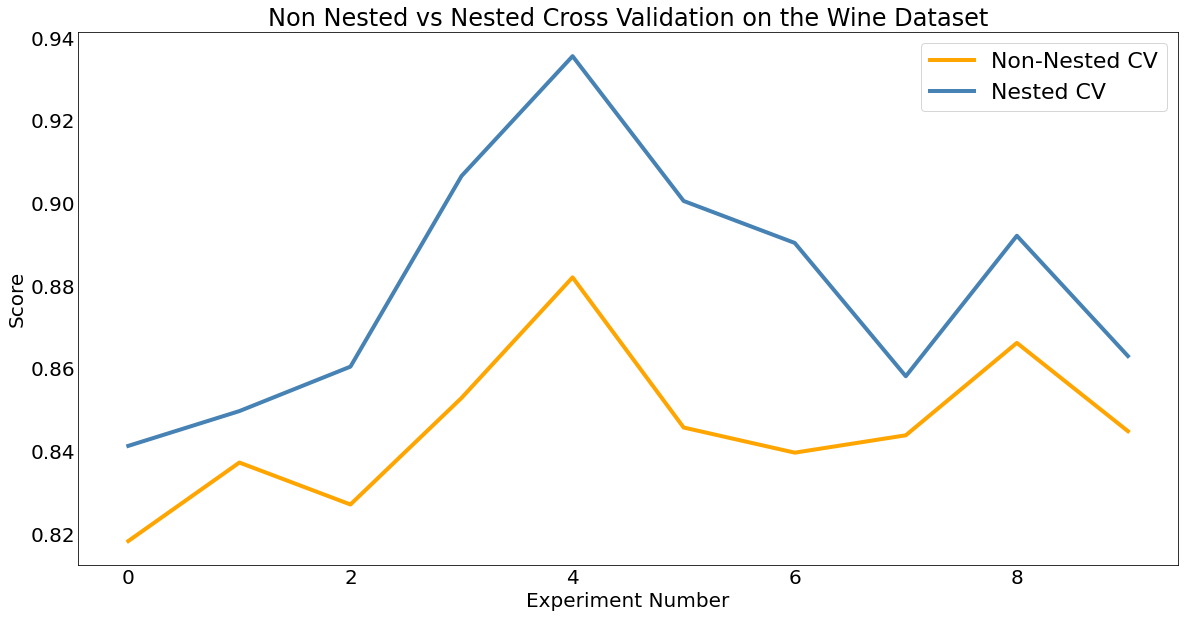

In [12]:
def plot_experiment(outer_scores, nested_scores, outpath=None):
    # Plot scores on each round for nested and non-nested cross validation
    fig, ax = plt.subplots(figsize=(16,8))
    fig.tight_layout()
    outer_scores_line, = ax.plot(np.abs(outer_scores), linewidth = 4, color='orange')
    nested_line, = ax.plot(np.abs(nested_scores), linewidth=4, color='steelblue')

    ax.tick_params(axis="both", which="both", length=0, labelsize=20)
    ax.grid(False)

    ax.set_ylabel("Score", fontsize="20")
    ax.set_xlabel("Experiment Number", fontsize="20")

    plt.legend([outer_scores_line, nested_line],
              ["Non-Nested CV", "Nested CV"],
               prop={'size': 22})
    plt.title("Non Nested vs Nested Cross Validation on the Wine Dataset",
             x=.5, y=1, fontsize="24")
    if outpath:
        plt.savefig(outpath, bbox_inches='tight')

plot_experiment(outer_scores, nested_scores, outpath="images/experiment_results.png")

### Concluding

Cross validation is standard practice in machine learning yet most organizations that do this create overly optimistic models. Among other reasons, this contributes to a frequently seen issue where models underperform in production compared to their performance in the building phase. On its own, nested cross validation does not provide us with a better model. And as we saw above, the computational cost of using mested cross validation can be high, especially with many hyperparameters and estimators. In exchange for time and compute power, it does allow us to properly and iteratively evaluate our models to produce realistic estimates of performance without using our holdout set. 

If you are interested in learning more or talking to me about this subject, feel free to look me up on [Github](https://github.com/mpkrass7) or add me on [Linkedin](https://www.linkedin.com/in/marshall-krassenstein/)! The greatest reward I have from doing any of this is hearing from people who took something away from my post.


## References
- KDNuggets https://www.kdnuggets.com/2020/10/nested-cross validation-python.html
- AnalyticsVidhya: https://www.analyticsvidhya.com/blog/2021/03/a-step-by-step-guide-to-nested-cross validation/
- Arxiv: https://arxiv.org/abs/1809.09446

Credits to Kevin Arvai and Justin Swansberg for auditing my understanding of this topic.